# SST Tutorial (Transformer + UNet)

### Getting Started

In [1]:
from pyshred import SHRED, SHREDDataManager, evaluate
from pyshred.datasets import sst_data

### Sensor & Data Processing

In [2]:
# sensor coordinates for 3 stationary sensors
coordinates = [(100,200),(90,190),(60,240)]

# Initialize SHREDDataManager
manager = SHREDDataManager(
    lags = 20,
    train_size = 0.7,
    val_size = 0.15,
    test_size = 0.15,
    compression = True, # defaults to 50 components
    mode = "all" # choose from: "reconstruct", "predict", "forecast", or "all"
)

# Add SST Data
manager.add(
    data = sst_data,
    stationary_sensors = [(46, 227),(120, 60),(134, 303)],
    id = "SST"
)

In [3]:
# summary of sensor locations/trajectories
manager.sensor_summary

,field id,sensor id,sensor type,location/trajectory
0,SST,SST-0,stationary (user selected),"(46, 227)"
1,SST,SST-1,stationary (user selected),"(120, 60)"
2,SST,SST-2,stationary (user selected),"(134, 303)"


In [4]:
# dataframe of sensor measurements
manager.sensor_measurements.head()

,time,SST-0,SST-1,SST-2
0,0,12.29,22.489999,13.57
1,1,11.83,23.589999,14.16
2,2,11.56,22.899999,14.97
3,3,11.02,23.719999,14.54
4,4,10.69,23.469999,15.31


### Dataset Splitting

In [5]:
train_dataset, val_dataset, test_dataset = manager.preprocess()

### Model Training

In [6]:
# initialize SHRED
shred = SHRED(
    sequence = "Transformer",
    decoder = "UNET"
)

# fit SHRED
val_errors = shred.fit(train_dataset, val_dataset, verbose=True)


Fitting Reconstructor...


Epoch 1/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 29.52batch/s, loss=0.0437, L2=0.438]/opt/miniconda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
Epoch 1000/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 180.38batch/s, loss=0.000176, L2=0.0299, val_loss=0.00414, val_L2=0.145]



Fitting Predictor...


Epoch 219/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 180.72batch/s, loss=0.00128, L2=0.0785, val_loss=0.0233, val_L2=0.33]


Early stopping triggered: patience threshold reached.

Fitting Sensor Forecaster...


Epoch 399/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 181.49batch/s, loss=0.000492, L2=0.0445, val_loss=0.00725, val_L2=0.175]

Early stopping triggered: patience threshold reached.


### Model Evaluation

In [7]:
evaluate(model = shred, dataset=test_dataset)

,L2 Error
reconstruction,0.141422
prediction,0.350940
forecast,0.382789
one-step sensor forecast,0.152237
rolling sensor forecast,0.372561


In [8]:
evaluate(model = shred, dataset=test_dataset, data_manager=manager)

,SST
reconstruction,0.014210
prediction,0.044066
forecast,0.076581
one-step sensor forecast,0.053774
rolling sensor forecast,0.133406


### Helper functions for plotting SST Data

In [9]:
### Helper functions for plotting SST Data
import matplotlib.pyplot as plt
import numpy as np

def plot_frame_comparison(data, data_truth, index, cmap="RdBu_r"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # Find global min and max for consistent color mapping
    vmin = min(data[index].min(), data_truth[index].min())
    vmax = max(data[index].max(), data_truth[index].max())
    # Plot Model Output
    im1 = axes[0].imshow(data[index], cmap=cmap, aspect="auto", vmin=vmin, vmax=vmax)
    axes[0].set_title("Model Output")
    axes[0].grid(False)
    # Plot Ground Truth
    im2 = axes[1].imshow(data_truth[index], cmap=cmap, aspect="auto", vmin=vmin, vmax=vmax)
    axes[1].set_title("Ground Truth")
    axes[1].grid(False)
    # Add a single shared colorbar
    cbar = fig.colorbar(im1, ax=axes, orientation="vertical", fraction=0.02, pad=0.04)
    # plt.tight_layout()
    plt.show()

def plot_frame_difference(data, data_truth, index, cmap="RdBu_r"):
    # Compute absolute error (difference map)
    error_map = np.abs(data[index] - data_truth[index])
    # Plot the difference map
    plt.figure(figsize=(10, 6))
    im = plt.imshow(error_map, cmap=cmap, aspect="auto")
    plt.colorbar(im)
    plt.title(f"Absolute Error")
    plt.grid(False)
    plt.show()

def plot_single_frame(data, index, cmap="RdBu_r"):
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(data[index], cmap=cmap, aspect="auto")
    # Add colorbar
    fig.colorbar(im, ax=ax)
    # Remove grid
    ax.grid(False)
    plt.show()

### Model Task: Reconstruct

In [10]:
### Reconstruct - Test Dataset
reconstruction = shred.reconstruct(test_dataset.reconstructor_dataset.X)
# Post-processing
recon_dict_out = manager.postprocess(reconstruction, mode = "reconstruct")
recon_dict_truth = manager.postprocess(test_dataset.reconstructor_dataset.Y.cpu().numpy(), mode = "reconstruct")

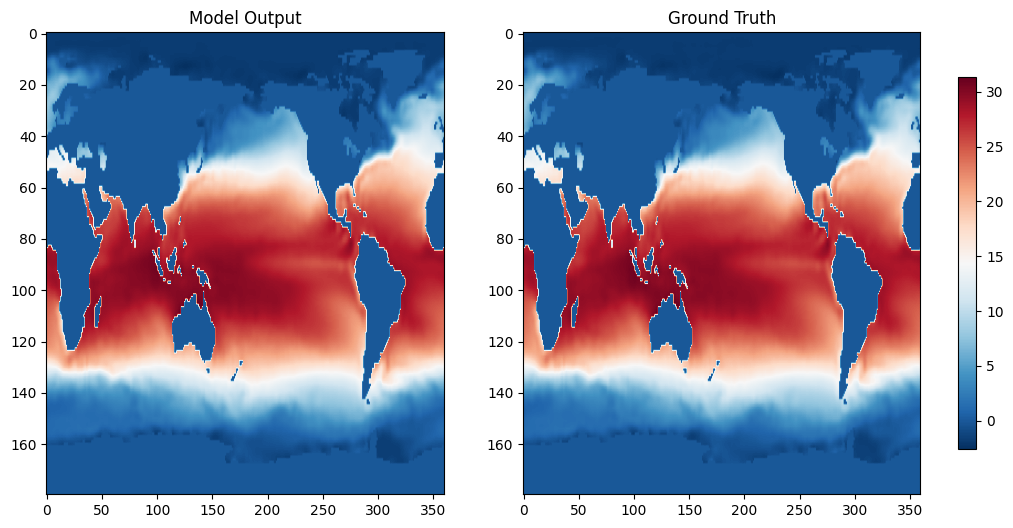

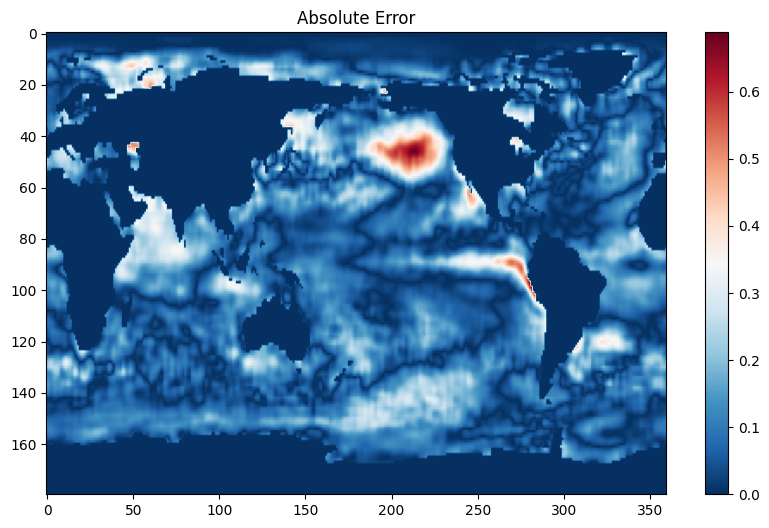

In [11]:
# Sample plot of Ground Truth vs. Reconstruction
index = 100
plot_frame_comparison(recon_dict_out["SST"], recon_dict_truth["SST"], index=100)
plot_frame_difference(recon_dict_out["SST"], recon_dict_truth["SST"], index=100)

### Model Task: Predict

In [12]:
# Predict - Test Dataset
prediction = shred.predict(test_dataset.predictor_dataset.X)
# Post-processing
pred_dict_out = manager.postprocess(prediction, mode = "predict")
pred_dict_truth = manager.postprocess(test_dataset.predictor_dataset.Y, mode = "predict")

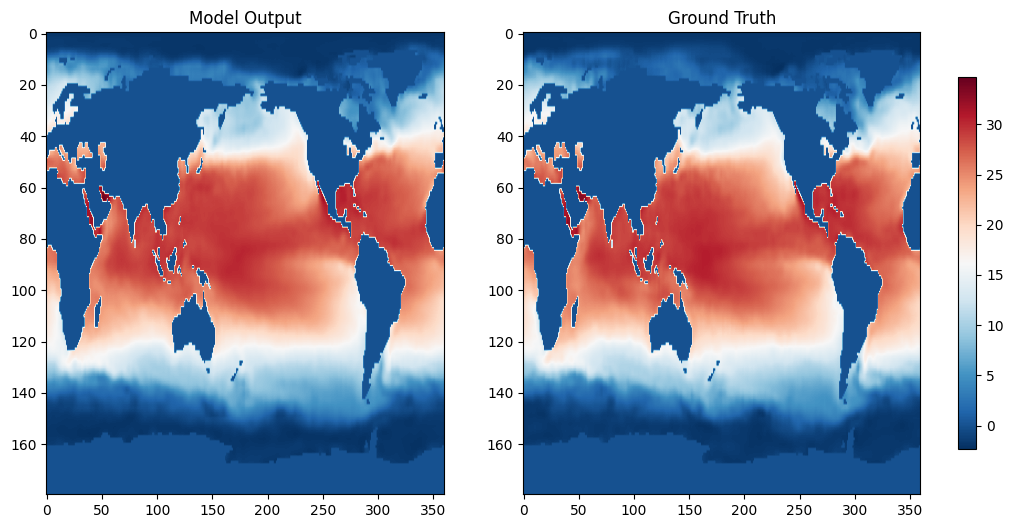

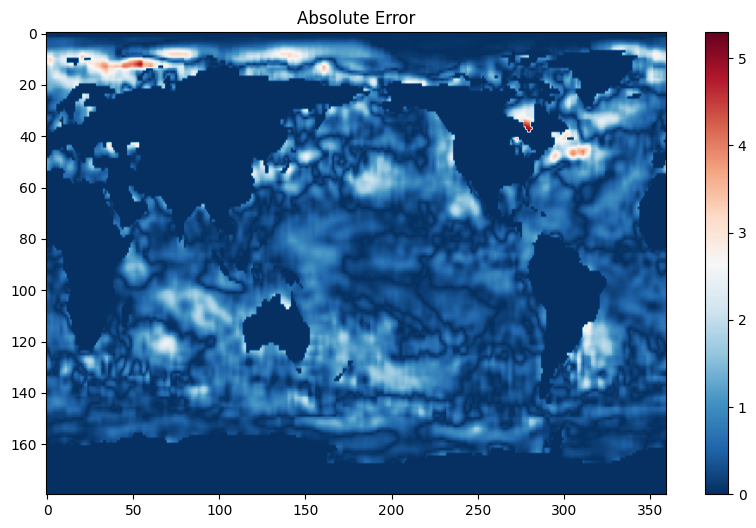

In [13]:
# Sample plot of Ground Truth vs. Prediction
index = 100
plot_frame_comparison(pred_dict_out["SST"], pred_dict_truth["SST"], index=100)
plot_frame_difference(pred_dict_out["SST"], pred_dict_truth["SST"], index=100)

### Model Task: Forecast

In [14]:
# Forecast Sensors from timestep 1400 to 1500 (inclusive)
forecasted_X = manager.generate_X(start = 1400, end = 1500, mode = "predict", forecaster = shred.sensor_forecaster)
# Predict using forecasted sensor measurements
forecast_out = shred.predict(forecasted_X)

# Post-processing
forecast_dict = manager.postprocess(forecast_out, mode = "predict")

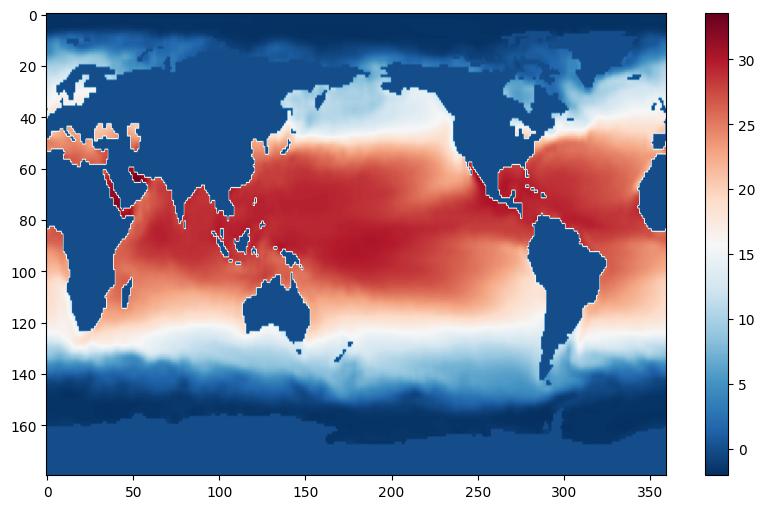

In [15]:
# Sample plot of model forecast at timestep = 1500
plot_single_frame(forecast_dict["SST"], index = 100)